In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# imports
import pandas as pd
import itertools
import os
from tqdm import tqdm
import time
import wandb
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['figure.dpi'] = 300

# Download Data

In [100]:
api = wandb.Api()

In [101]:
def get_wandb_data(api, project, csv_path):
    records = []
    runs = api.runs(path=project)
    for run in tqdm(runs):
        run_info_keys = ['base_game_name', 'rule', 'cfg', 'rho', 'seed']
        run_info = {k: run.config[k] for k in run_info_keys}

        run_records = list(run.scan_history(keys=['global_step', 'nash_conv', '_runtime']))
        run_records = [{**record, **run_info} for record in run_records]
        records += run_records

        time.sleep(1)
        
    df = pd.DataFrame.from_records(records)
    df.to_csv(csv_path, index=False)

In [59]:
get_wandb_data(api, 'ubc-algorithms/feb10_speed_v1', '/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb10_speed_v1.csv')

100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


In [24]:
get_wandb_data(api, 'ubc-algorithms/feb12_speed_v1', '/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb12_speed_v1.csv')

100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


In [102]:
get_wandb_data(api, 'ubc-algorithms/feb12_speed_extracombos_v1', '/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb12_speed_extracombos_v1.csv')

100%|██████████| 200/200 [04:32<00:00,  1.36s/it]


# Plot Results

In [121]:
df = pd.concat((
    pd.read_csv('/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb10_speed_v1.csv').query('rho == 0'),
    pd.read_csv('/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb12_speed_extracombos_v1.csv'),
    pd.read_csv('/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb12_speed_v1.csv'),
))

In [122]:
run_length_df = df.groupby(['base_game_name', 'rule', 'cfg', 'rho', 'seed'])['global_step'].max().reset_index()
run_length_df.groupby(['base_game_name', 'rule'])['global_step'].min()

base_game_name    rule     
feb10_2p_5type_0  base         4100
                  tie_break    3600
feb10_2p_5type_1  base         5800
                  tie_break    4200
feb10_2p_5type_2  base         7500
                  tie_break    5000
feb10_2p_5type_3  base         9800
                  tie_break    8700
feb10_2p_5type_4  base         9200
                  tie_break    8600
Name: global_step, dtype: int64

Plot idea 1: median NashConv over time

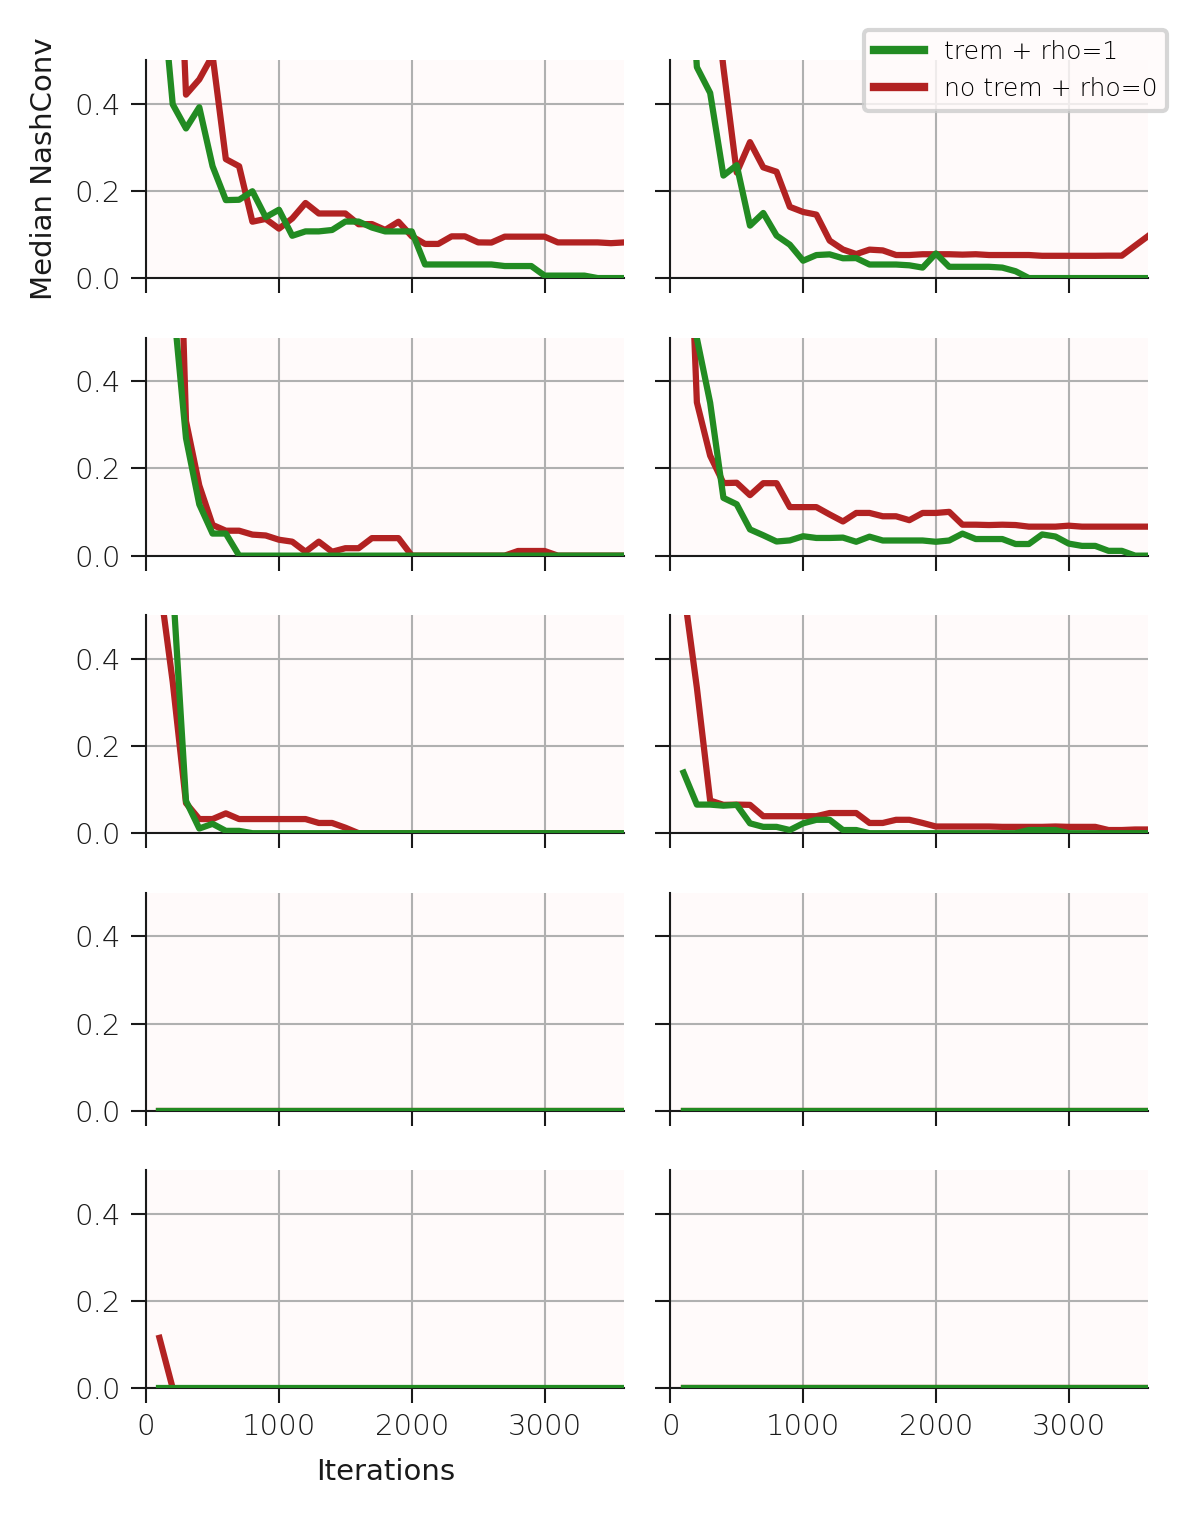

In [34]:
base_game_names = sorted(df['base_game_name'].unique())
rules = df['rule'].unique()
configs = df['cfg'].unique()

CFR_PRETTY_NAMES_AND_COLORS = {
    'cfr_10/external_plus_linear': ('trem + rho=1', 'forestgreen'),
    'cfr_10_no_trem/external_plus_linear_no_trem': ('no trem + rho=0', 'firebrick'),
}

MAX_STEPS = 3600
q_list = [0.1, 0.3, 0.5, 0.7, 0.9]
q = 0.5

fig, ax_list = plt.subplots(5, 2, figsize=(4, 5))
for i, (base_game_name, rule) in enumerate(itertools.product(base_game_names, rules)):
    plt.sca(ax_list.flatten()[i])
    for cfg in configs:
        sub_df = df[(df['base_game_name'] == base_game_name) & (df['rule'] == rule) & (df['cfg'] == cfg) & (df['global_step'] <= MAX_STEPS)]
        quantiles = sub_df.groupby('global_step')['nash_conv'].quantile(q_list).unstack()

        plt.plot(quantiles.index, quantiles[q], color=CFR_PRETTY_NAMES_AND_COLORS[cfg][1], clip_on=True, zorder=10)
        # for q_ in q_list:
        #     plt.plot(quantiles.index, quantiles[q_], color=CFR_PRETTY_NAMES_AND_COLORS[cfg][1], linewidth=0.5, alpha=0.5, clip_on=True, zorder=10)
        # plt.fill_between(quantiles.index, quantiles[0.1], quantiles[0.9], facecolor=CFG_TO_COLOR[cfg], alpha=0.2, clip_on=True, zorder=10)
    
    plt.xlim(0, MAX_STEPS)
    plt.ylim(0, 0.5)

ax_list[0, 0].set_ylabel('Median NashConv')
ax_list[-1, 0].set_xlabel('Iterations')
for iy, ix in itertools.product(range(5), range(2)):
    if ix != 0:
        ax_list[iy, ix].set_yticklabels([])
    if iy != len(ax_list) - 1:
        ax_list[iy, ix].set_xticklabels([])

fig.subplots_adjust(bottom=0.35)
custom_lines = [Line2D([0], [0], color=CFR_PRETTY_NAMES_AND_COLORS[p][1], lw=2) for p in CFR_PRETTY_NAMES_AND_COLORS]
fig.legend(custom_lines, [CFR_PRETTY_NAMES_AND_COLORS[p][0] for p in CFR_PRETTY_NAMES_AND_COLORS], loc='upper right', fontsize=6, bbox_to_anchor=(1,1), ncol=1)


plt.tight_layout()
plt.show()

Plot idea 2: boxplot of NashConv at key points

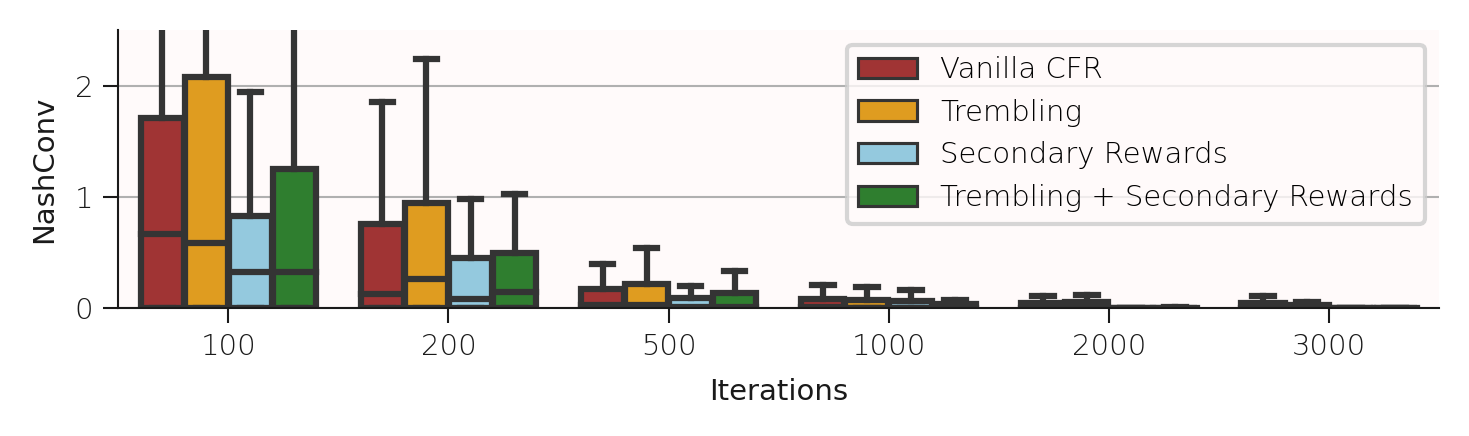

In [146]:
base_game_names = sorted(df['base_game_name'].unique())
rules = df['rule'].unique()
configs = df['cfg'].unique()
rhos = df['rho'].unique()

CFR_PRETTY_NAMES_AND_COLORS = {
    'cfr_10_no_trem/external_plus_linear_no_trem_0': ('Vanilla CFR', 'firebrick'),
    'cfr_10/external_plus_linear_0': ('Trembling', 'orange'),
    'cfr_10_no_trem/external_plus_linear_no_trem_1': ('Secondary Rewards', 'skyblue'),
    'cfr_10/external_plus_linear_1': ('Trembling + Secondary Rewards', 'forestgreen'),
}

STEPS = [100, 200, 500, 1000, 2000, 3000]

df_steps = df.query(f'global_step in {STEPS}').copy()
df_steps['config_and_rho'] = df_steps['cfg'] + '_' + df_steps['rho'].astype(str)
df_steps['config_pretty'] = df_steps['config_and_rho'].apply(lambda x: CFR_PRETTY_NAMES_AND_COLORS[x][0])
df_steps['log_nash_conv'] = np.log(df_steps['nash_conv'] + 1e-6)
# df_steps.sort_values('config_and_rho')

plt.figure(figsize=(5, 1.5))
sns.boxplot(df_steps, x='global_step', y='nash_conv', hue='config_pretty', showfliers=False, palette={v[0]: v[1] for v in CFR_PRETTY_NAMES_AND_COLORS.values()}, hue_order=['Vanilla CFR', 'Trembling', 'Secondary Rewards', 'Trembling + Secondary Rewards'])
plt.xlabel('Iterations')
plt.ylabel('NashConv')
plt.ylim(0, 2.5)
plt.legend(title='')
plt.tight_layout()
plt.savefig('/global/scratch/open_spiel/open_spiel/notebooks/greg/figures/cfr_tuning/cfr_nash_conv.png', pad_inches=0.05, bbox_inches='tight')
plt.show()
